In [1]:
import pandas as pd
import os
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# 读取CSV文件
return_data = pd.read_csv("../Data/ReportReturn.csv")

# 定义年报文本文件所在目录
report_directory = '../Data/FilteredReports'

# 初始化一个新的列，用于存储文本内容
return_data['text'] = None

# 遍历DataFrame的每一行
for index, row in return_data.iterrows():
    # 根据pdf文件名生成对应的txt文件名
    report_name_pdf = row['report']
    report_name_txt = report_name_pdf.replace('.pdf', '.txt')
    
    # 构建txt文件的完整路径
    file_path = os.path.join(report_directory, report_name_txt)
    
    # 检查文件是否存在
    if os.path.exists(file_path):
        # 读取文件内容
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        
        # 将文本内容添加到DataFrame对应行
        return_data.at[index, 'text'] = text
    else:
        print(f"File not found: {file_path}")

# 将文本数据转换为TaggedDocument格式，用于Doc2Vec模型训练
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(index)]) for index, doc in return_data['text'].items()]

In [3]:
# 训练Doc2Vec模型
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4)
doc2vec_model.build_vocab(tagged_data)
for epoch in range(10):  # 训练10个epochs
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=1)

# 为每个报告计算文档向量
def compute_document_vector(model, text):
    words = text.split()
    vectors = [model.infer_vector(doc.words) for doc in [TaggedDocument(words=words, tags=[''])]]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 计算文档向量并存储在DataFrame中
return_data['doc_vector'] = return_data['text'].apply(lambda text: compute_document_vector(doc2vec_model, text))

# 准备特征矩阵X和目标变量y
X = np.vstack(return_data['doc_vector'].dropna().values)  # 移除NaN值
y = return_data['rtn1y'].dropna().values  # 确保y与X的行数相同

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练线性回归模型
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 进行预测
y_pred = linear_model.predict(X_test)

# 计算均方误差
mse_doc2vec = mean_squared_error(y_test, y_pred)
print(f"Doc2Vec Model MSE: {mse_doc2vec}")

Doc2Vec Model MSE: 0.2016351893623013


In [12]:
y2 = return_data['rtn2y'].dropna().values
X2_train,X2_test,y2_train,y2_test = train_test_split(X,y2,test_size=0.2,random_state=42)
model2 = LinearRegression()
model2.fit(X2_train,y2_train)
y2_pred = model2.predict(X2_test)
mse_doc2vec2 = mean_squared_error(y2_test,y2_pred)
print(f'Do2Vec Model for year2 MSE:{mse_doc2vec2}')

Do2Vec Model for year2 MSE:0.08559079879197484


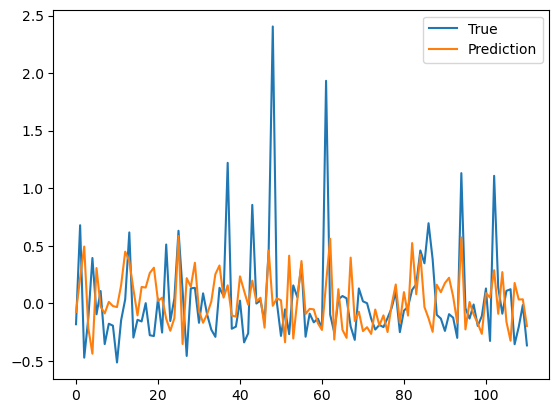

In [4]:
# 绘制真实值和预测值的对比图
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Prediction')
plt.legend()
plt.show()  # 显示图表

In [18]:
res = pd.read_csv('../Data/res.csv',index_col=0)
mse_res = pd.read_csv('../Data/mse_res.csv',index_col=0)
res['doc2vec_pred1y'] = y_pred
res['doc2vec_pred2y'] = y2_pred
mse_res.loc['1y','doc2vec_mse'] = mse_doc2vec
mse_res.loc['2y','doc2vec_mse'] = mse_doc2vec2
res.to_csv('../Data/res.csv',)
mse_res.to_csv('../Data/mse_res.csv')